<a href="https://colab.research.google.com/github/Tarunkumar1995/Face-Mask-Detection/blob/master/facemaskdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [3]:
directory=r'/content/drive/My Drive/TensorFlow/facemaskdetection'




In [ ]:
directory=r'/content/drive/My Drive/TensorFlow/facemaskdetection'

category=os.listdir(directory)
data=[]
labels=[]
for link in category:
  path=os.path.join(directory,link)     ##path of the sub folder
  for img in os.listdir(path):   #path of the image in a subfolder
    img_path=os.path.join(path,img)  #getting path of the image
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image) ##preprocces function used to adequate the images as our model requires

    data.append(image)
    labels.append(link)
    

In [ ]:
len(data)

3833

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelBinarizer


In [ ]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

#we will convert them into numpy arrays bcz deep learning works only  with numpy arrays faster

data=np.array(data)
labels=np.array(labels)

In [ ]:
link='/content/drive/My Drive/TensorFlow/facemaskdetection'

with_mask=link + '/with_mask'
without_mask=link + '/without_mask'


print("length of the data of with_maks {}".format(len(os.listdir(with_mask))))
print("lenght of the data of without mask {}".format(len(os.listdir(without_mask))))

length of the data of with_maks 1915
lenght of the data of without mask 1918


In [ ]:
datagen=ImageDataGenerator()
images=datagen.flow_from_directory(directory='/content/drive/My Drive/TensorFlow/facemaskdetection')


Found 3833 images belonging to 2 classes.


In [ ]:
images.class_indices

{'with_mask': 0, 'without_mask': 1}

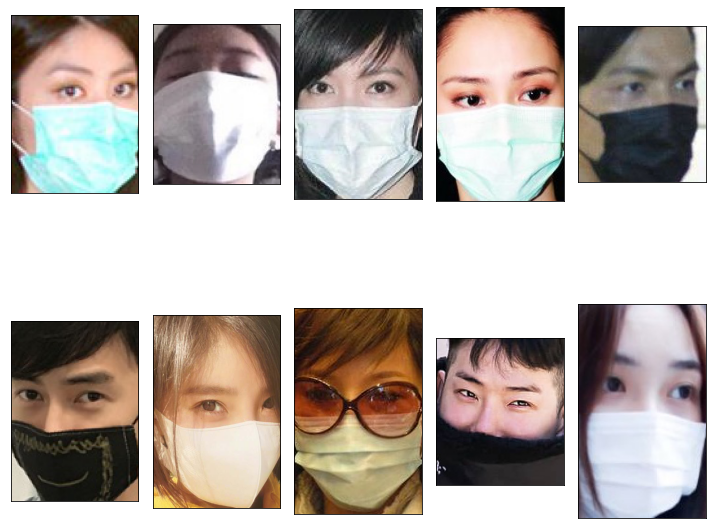

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for a,b in enumerate(images.filepaths[:10]):
  plt.subplot(2,5,a+1)
  img=load_img(b)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show() 
  

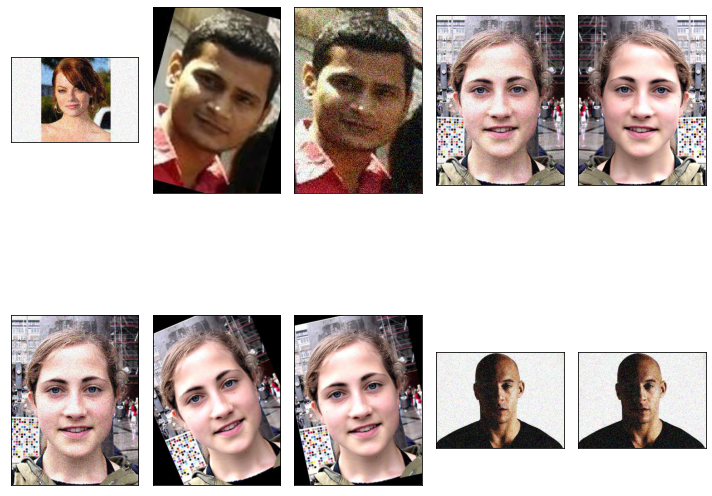

In [ ]:
plt.figure(figsize=(10,10))
for a,b in enumerate(images.filepaths[-10:]):
  plt.subplot(2,5,a+1)
  img=load_img(b)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

To know more about Imagedata generator parameters [click](https://fairyonice.github.io/Learn-about-ImageDataGenerator.html)

#Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data,labels,random_state=23,test_size=0.25,stratify=labels,shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2874, 224, 224, 3)
(959, 224, 224, 3)
(2874, 2)
(959, 2)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Activation,Dropout,AveragePooling2D,Flatten,Input
from tensorflow.keras.models import Sequential

In [ ]:
model=Sequential()
model.add(MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3)))
for layer in model.layers:
  layer.trainable=False

model.add(AveragePooling2D(pool_size=(5,5)))
model.add(Flatten(name='flatten'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))


loss=tf.keras.losses.binary_crossentropy
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
______________________________________

In [ ]:
#constructing an image constructor
aug = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.2,fill_mode='nearest',zoom_range=0.15,horizontal_flip=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping=EarlyStopping(monitor='loss',patience=3,mode='min')
Accuracy_Threshold=0.98
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('accuracy')> Accuracy_Threshold):
      print("\nReached %2.2f%% accuracy, so stop training" %(Accuracy_Threshold*100))
      self.model.stop_training=True

callback=mycallback()

In [ ]:
bs=32
fitted_model=model.fit(aug.flow(X_train,y_train),
                       steps_per_epoch=len(X_train)//bs,
                       validation_data=(X_test,y_test),
                       validation_steps=len(X_test)//bs,
                       epochs=10,callbacks=[callback,earlystopping])

Epoch 1/10
89/89 [==============================] - 29s 330ms/step - loss: 0.6539 - accuracy: 0.9170 - val_loss: 0.0636 - val_accuracy: 0.9812
Epoch 2/10
89/89 [==============================] - 29s 322ms/step - loss: 0.0740 - accuracy: 0.9771 - val_loss: 0.0269 - val_accuracy: 0.9917
Epoch 3/10
89/89 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9806
Reached 98.00% accuracy, so stop training
89/89 [==============================] - 28s 319ms/step - loss: 0.0673 - accuracy: 0.9806 - val_loss: 0.0415 - val_accuracy: 0.9844


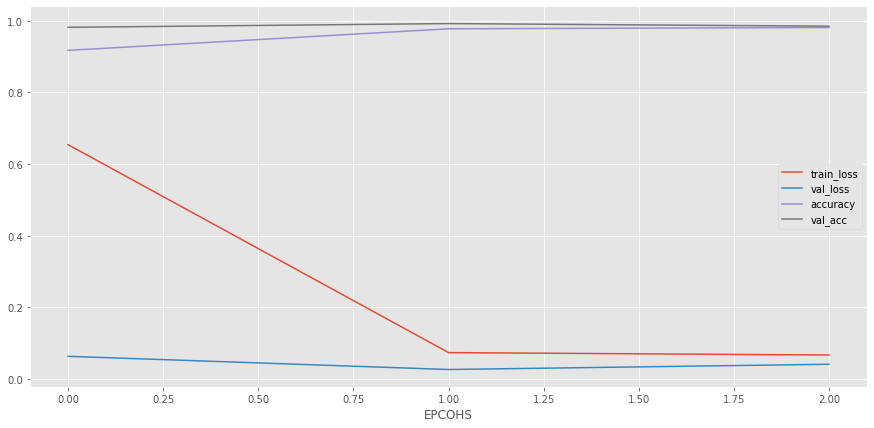

In [ ]:
N=3

plt.style.use('ggplot')
plt.figure(figsize=(15,7))
plt.plot(np.arange(0,N),fitted_model.history['loss'],label='train_loss')
plt.plot(np.arange(0,N),fitted_model.history['val_loss'],label='val_loss')
plt.plot(np.arange(0,N),fitted_model.history['accuracy'],label='accuracy')
plt.plot(np.arange(0,N),fitted_model.history['val_accuracy'],label='val_acc')
plt.xlabel("EPCOHS")
plt.legend()
plt.show()

In [ ]:
pred=model.predict(X_test,batch_size=bs)

In [ ]:
#finding the highest predicted probabilities

pred=np.argmax(pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1),pred,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.98      0.98       479
without_mask       0.98      0.99      0.98       480

    accuracy                           0.98       959
   macro avg       0.98      0.98      0.98       959
weighted avg       0.98      0.98      0.98       959



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


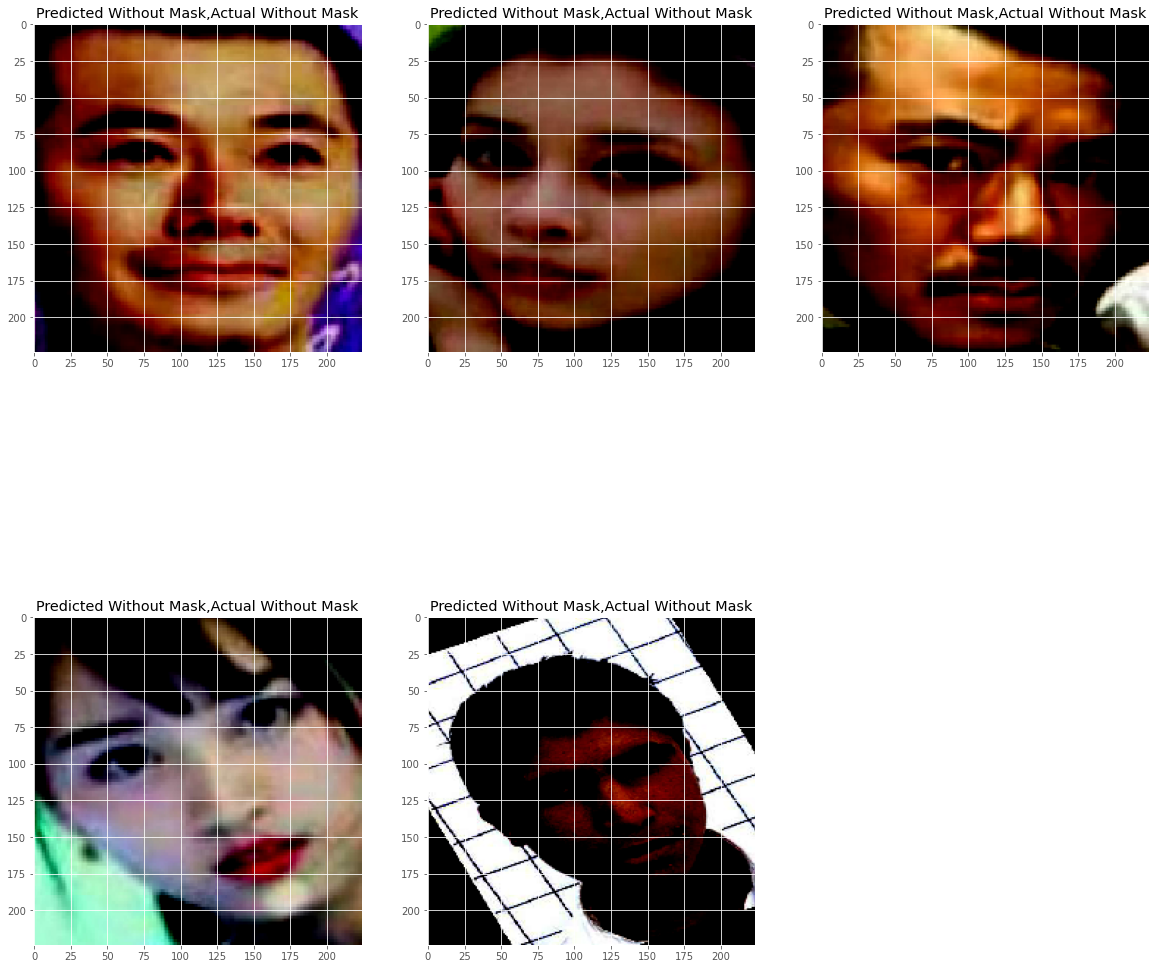

In [ ]:
import random
res = ["With Mask","Without Mask"]
plt.figure(figsize=(20,20))
for a,b in enumerate(range(5)):
  plt.subplot(2,3,a+1)
  im = random.randint(1,500)
  plt.imshow(X_test[im])
  plt.title("Predicted {},Actual {}".format(res[pred[im]],res[np.argmax(y_test[im])] ))


In [ ]:
#Finally saving our model as mask_detector.model, saving it in h5 format
print("Saving mask detector....")
model.save("FaceMaskDetector.model",save_format='h5')
print("\n Saved")

Saving mask detector....


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import cv2
import numpy as np


In [ ]:
def prediction(image):
  res=['with mask','without_mask']
  img=image
  img_load=load_img(img,target_size=(224,224))
  img_array=img_to_array(img_load)
  img_pre=preprocess_input(img_array)
  #print(img_pre.shape)
  img_dim=np.expand_dims(img_pre,axis=0)
  #print(img_dim.shape)
  pred=model.predict(img_dim)
  return res[np.argmax(pred)]



In [ ]:
prediction(filename)

'with mask'